<a href="https://colab.research.google.com/github/frferreira/Ifes-IA/blob/master/Problema_Heuristica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import fetch_openml
import numpy as np

In [11]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
# X, y = iris_dataset.data, iris_dataset.target

X, y = iris_dataset.data[:,2:], iris_dataset.target


In [3]:
X,y


(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [4]:
def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

In [5]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris_dataset.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris_dataset.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris_dataset.feature_names[1]}")
    plt.show()

In [15]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i,k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades**2)
  return result




In [14]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezaMaiores = impureza(y[maiores])
  propMaiores = sum(maiores)/len(y)
  impurezaMenores = impureza(y[~maiores])
  propMenores = sum(~maiores)/len(y)
  impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
  return impurezaTotal, impurezaMaiores, impurezaMenores


In [16]:

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    valor = np.median(x)
    #valor = (xmin+xmax)/2
    while True:  
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

In [8]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return caracteristica, valores[caracteristica], impurezas[caracteristica]

In [9]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

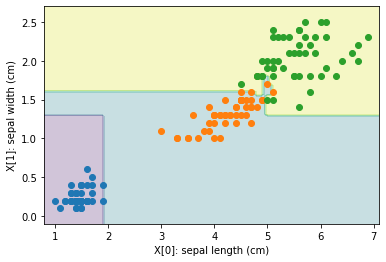

In [12]:
plotDecisao(Arvore(), X, y)

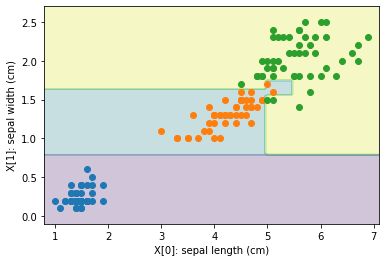

In [17]:
from sklearn.tree import DecisionTreeClassifier
plotDecisao(DecisionTreeClassifier(), X, y)

In [18]:
from sklearn.model_selection import cross_validate
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.83333333, 0.9       , 1.        ]),
 0.9333333333333332)

In [27]:
# montando um classificador 
request = fetch_openml(data_id=1046,as_frame=True)
X1 = request.data
y1 = request.target


In [28]:
X1

,id,start,end,event,size
0,1.0,0.0,913439.0,0.0,14.0
1,1.0,913439.0,1292405.0,1.0,14.0
2,1.0,1292405.0,1540749.0,0.0,14.0
3,2.0,0.0,50170.0,0.0,14.0
4,3.0,0.0,913439.0,0.0,18.0
...,...,...,...,...,...
15540,879.0,97360.0,130256.0,0.0,1511.0
15541,879.0,130256.0,132045.0,1.0,1513.0
15542,879.0,132045.0,132393.0,0.0,1502.0
15543,879.0,132393.0,207343.0,0.0,1517.0


In [29]:
y1


0        0
1        0
2        1
3        0
4        0
        ..
15540    1
15541    1
15542    1
15543    1
15544    0
Name: state, Length: 15545, dtype: category
Categories (2, object): ['0', '1']

In [30]:
request = fetch_openml(data_id=40691,as_frame=True)
X2 = request.data
y2 = request.target
X2

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [31]:
y2

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: class, Length: 1599, dtype: category
Categories (6, object): ['3', '4', '5', '6', '7', '8']

In [36]:
request = fetch_openml(data_id=1464,as_frame=True)
X3 = request.data
y3 = request.target
X3

,V1,V2,V3,V4
0,2.0,50.0,12500.0,98.0
1,0.0,13.0,3250.0,28.0
2,1.0,16.0,4000.0,35.0
3,2.0,20.0,5000.0,45.0
4,1.0,24.0,6000.0,77.0
...,...,...,...,...
743,23.0,2.0,500.0,38.0
744,21.0,2.0,500.0,52.0
745,23.0,3.0,750.0,62.0
746,39.0,1.0,250.0,39.0


In [37]:
y3

0      2
1      2
2      2
3      2
4      1
      ..
743    1
744    1
745    1
746    1
747    1
Name: Class, Length: 748, dtype: category
Categories (2, object): ['1', '2']